In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


import pytorch_lightning as pl
import TrajNet_train
import utils
import torch

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

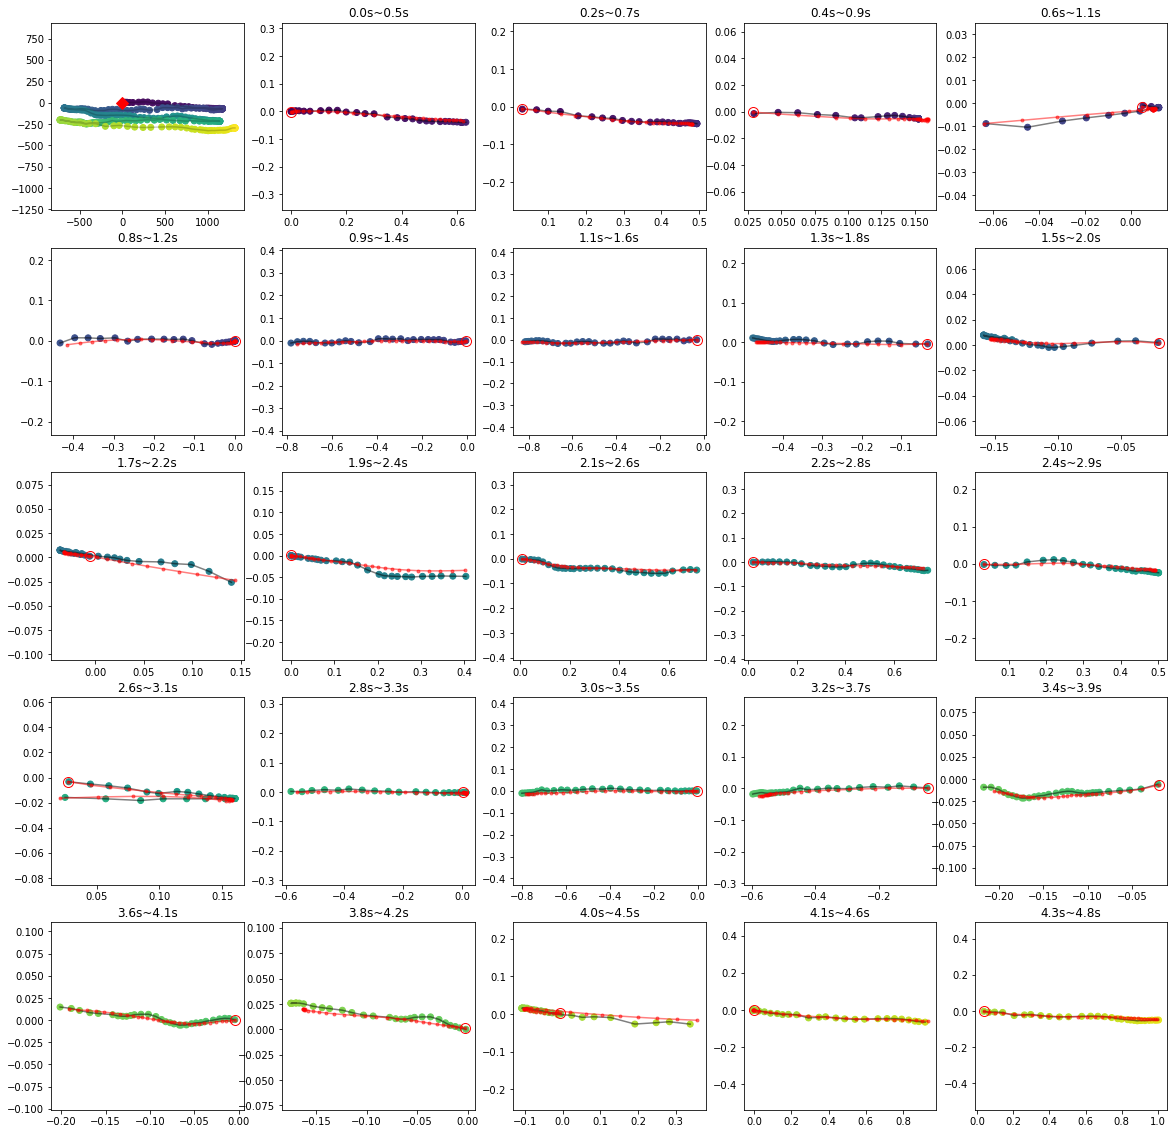

In [4]:

subj = utils.ExpInfo.getSubjIDs()[25]
task = 'one_dot'
fig, ax = utils.Plot.traj_and_Reconstruc_quick_check(subj, task, 22)

In [ ]:

def traj_and_Reconstruc_from_batch(x, y, x_full=None, fig=None, nSegment=24, nCol=5, cmap='viridis'):
    nBatch = x.shape[0]
    plot_offset = 0
    
    # compute starting points of segments
    start_idx = np.linspace(0, nBatch, nSegment + 1).astype(int)[:-1]
    nRow = np.ceil((nSegment+1) / nCol).astype(int)
    
    # setup colormap
    if x_full is None:
        t_len = 301
    else:
        t_len = x_full.shape[0]
    colors = np.linspace(0, 1, t_len)
    cmap = mpl.cm.get_cmap(cmap)

    # setup figure
    if fig is None:
        fig = plt.figure(figsize=(4*nRow, 4*nCol))
    ax = fig.subplots(nRow, nCol)
    if ax.ndim == 1:
        ax = ax.reshape(1, -1)

    # plot full trajectory
    if x_full is not None:
        ax[0, 0].plot(x_full[:, 0], x_full[:, 1], '-k', alpha=0.2)
        ax[0, 0].scatter(x_full[:, 0], x_full[:, 1], c=colors, cmap=cmap)
        ax[0, 0].plot(0, 0, 'Dr', label='start', markersize=8)
        ax[0, 0].axis('equal')
        plot_offset = 1

    for i, si in enumerate(start_idx):
        iRow, iCol = np.unravel_index(i+plot_offset, (nRow, nCol))
        
        # plot ground Truth
        ax[iRow, iCol].scatter(x[si, :, 0], x[si, :, 1], c=cmap(colors[si:si+wSize]), marker='o')
        ax[iRow, iCol].plot(x[si, :, 0], x[si, :, 1], 'k', alpha=0.5)
        ax[iRow, iCol].axis('equal')
        
        # plot reconstructed
        ax[iRow, iCol].plot(y[si, 0, 0], y[si, 0, 1], 'ro', mfc='none', markersize=10)
        ax[iRow, iCol].plot(y[si, :, 0], y[si, :, 1], color='red', alpha=0.5)
        ax[iRow, iCol].plot(y[si, :, 0], y[si, :, 1], '.', color='red', alpha=0.5)
        ax[iRow, iCol].axis('equal')
        ax[iRow, iCol].set_title(f'{si/60:.1f}s~{(si+wSize)/60:.1f}s')

    return fig, ax


In [ ]:
def traj_and_Reconstruc_from_trial(df, trialno, model, wSize=30, **kwargs):
    # extract data
    df = df.query(f'trialno == {trialno}')
    x = utils.DataProcessing.rollingWindow_from_df(df, wSize, 1)
    
    # run reconstruction
    model.eval()
    x_ = torch.from_numpy(x).double()
    y = model(x_).detach().cpu().numpy()
    
    # cumsum
    x_cum = x.cumsum(axis=1)
    y_cum = y.cumsum(axis=1)
    x_full = df[['x-shift', 'y-shift']].values
    x_full = x_full.cumsum(axis=0)
    
    return traj_and_Reconstruc_from_batch(x_cum, y_cum, x_full=x_full, **kwargs)


(<Figure size 1440x1440 with 25 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:title={'center':'0.0s~0.5s'}>,
         <AxesSubplot:title={'center':'0.2s~0.7s'}>,
         <AxesSubplot:title={'center':'0.4s~0.9s'}>,
         <AxesSubplot:title={'center':'0.6s~1.1s'}>],
        [<AxesSubplot:title={'center':'0.8s~1.2s'}>,
         <AxesSubplot:title={'center':'0.9s~1.4s'}>,
         <AxesSubplot:title={'center':'1.1s~1.6s'}>,
         <AxesSubplot:title={'center':'1.3s~1.8s'}>,
         <AxesSubplot:title={'center':'1.5s~2.0s'}>],
        [<AxesSubplot:title={'center':'1.7s~2.2s'}>,
         <AxesSubplot:title={'center':'1.9s~2.4s'}>,
         <AxesSubplot:title={'center':'2.1s~2.6s'}>,
         <AxesSubplot:title={'center':'2.2s~2.8s'}>,
         <AxesSubplot:title={'center':'2.4s~2.9s'}>],
        [<AxesSubplot:title={'center':'2.6s~3.1s'}>,
         <AxesSubplot:title={'center':'2.8s~3.3s'}>,
         <AxesSubplot:title={'center':'3.0s~3.5s'}>,
         <AxesSubplot:title={'center':'3.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

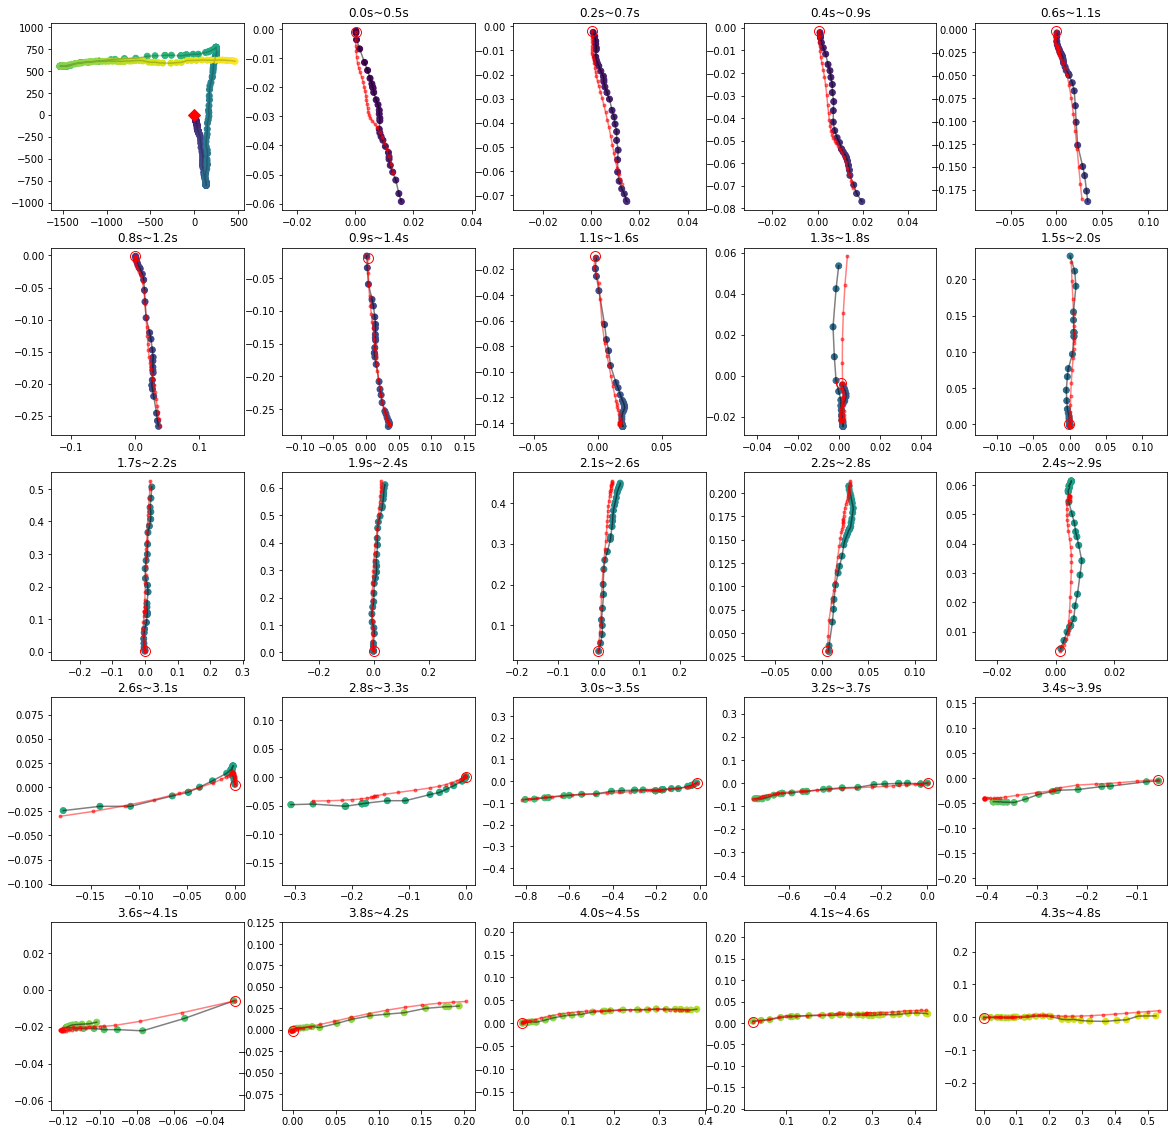

In [175]:
def traj_and_Reconstruc_quick_check(subj, task, trialno, model_type='val', **kwargs):
    df = utils.LoadData.mouseMovement(subj, task)
    model = TrajNet_train.PL_model()
    path_cp = utils.path_data / 'TrajNet_train' / f'{subj}_one_dot_{model_type}.ckpt'
    model = model.load_from_checkpoint(path_cp).double()
    return traj_and_Reconstruc_from_trial(df, trialno=trialno, model=model, **kwargs)

subj = utils.ExpInfo.getSubjIDs()[25]
task = 'one_dot'
traj_and_Reconstruc_quick_check(subj, task, 1)

In [ ]:
np.unravel_index(3, (1, 4))


In [ ]:
dataset_train, dataset_val = utils.LoadData.mouseMovementRollingData(subjID=subj, 
                                                                     task=task, 
                                                                     wSize=TrajNet_train.config['wSize'], 
                                                                     pos=TrajNet_train.config['pos'], 
                                                                     seed=0)


In [ ]:
d = dataset_train[0:10]
nLine = d.shape[0]
nTime = d.shape[1]

d = d.cumsum(axis=1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(nLine):
    ax.plot(d[i, :, 0], d[i, :, 1])


In [ ]:
d = dataset_train[range(0, 1000, 100)]
d = d.cumsum(axis=1)
nLine = d.shape[0]
nTime = d.shape[1]


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(nLine):
    ax.plot(np.ones(nTime)*i, d[i, :, 0], d[i, :, 1])


